In [1]:
!pip install pandas
!pip install community
!pip install openpyxl
!pip install scipy
!pip install scikit-learn
!pip install collections
!pip install surprise

  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)
  Using cached community-1.0.0b1-py3-none-any.whl
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached werkzeug-3.0.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
Using cached flask-3.0.3-py3-none-any.whl (101 kB)
Using cached itsdangerous-2.2.0-py3-none-any.whl (16 kB)
Using cached werkzeug-3.0.3-py3-none-any.whl (227 kB)
  Using cached openpyxl-3.1.4-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl.metadata (1.8 kB)
Using cached openpyxl-3.1.4-py2.py3-none-any.whl (251 kB)
Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
  Using cached sci

In [2]:
import pandas as pd
import networkx as nx
from networkx.algorithms import community
import community as community_louvain

import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
df_2009_2010 = pd.read_excel('online_retail_2.xlsx', sheet_name='Year 2009-2010')
df_2010_2011 = pd.read_excel('online_retail_2.xlsx', sheet_name='Year 2010-2011') 

In [4]:
# Combine the dataframes into one
df = pd.concat([df_2009_2010, df_2010_2011], ignore_index=True)

In [5]:
df['Customer ID'] = df['Customer ID'].astype('Int64')
df = df.dropna(subset=['Customer ID', 'StockCode'])

In [6]:
# Convert Customer ID to string if you want to avoid any ambiguity with number types
df['Customer ID'] = df['Customer ID'].astype(str)
df['StockCode'] = df['StockCode'].astype(str)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [7]:
# Remove rows where 'Quantity' is less than 1 or 'Price' is less than 0
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Remove records where 'StockCode' is 'TEST001'
df = df[df['StockCode'] != 'TEST001']

# Check the first few rows to ensure the filtering is done
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [8]:
# Add additional columns for year and month
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate the total price for each row
df['TotalPrice'] = df['Quantity'] * df['Price']

# Check the first few rows to ensure we have total price column
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009,12,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009,12,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009,12,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009,12,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009,12,30.0


In [9]:
# Using 'size' to count the number of rows for each country
country_groupby_count = df.groupby('Country').size().reset_index(name='Count')
country_groupby_count

,Country,Count
0,Australia,1812
1,Austria,922
2,Bahrain,59
3,Belgium,3068
4,Brazil,94
5,Canada,228
6,Channel Islands,1569
7,Cyprus,1155
8,Czech Republic,25
9,Denmark,798


In [17]:
# Create an empty bipartite graph
B = nx.Graph()

# Add nodes with the node attribute "bipartite"
customer_nodes = df['Customer ID'].unique()
product_nodes = df['StockCode'].unique()

B.add_nodes_from(customer_nodes, bipartite=0)  # Customers
B.add_nodes_from(product_nodes, bipartite=1)  # Products

# Add edges with the invoice as a weight or as an edge attribute
for index, row in df.iterrows():
    B.add_edge(row['Customer ID'], row['StockCode'], invoice=row['Invoice'])

print(B)

Graph with 10457 nodes and 481930 edges


In [11]:
pip install python-louvain --upgrade

  Using cached python_louvain-0.16-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [18]:
# It is important to import community as follows
import community.community_louvain as community_louvain

# Detect the best partition
partition = community_louvain.best_partition(B)

# Add community info to the network
for node, comm in partition.items():
    B.nodes[node]['community'] = comm

# To see the number of communities and their sizes:
community_sizes = dict()
for node in B.nodes(data=True):
    community = node[1]['community']
    community_sizes[community] = community_sizes.get(community, 0) + 1

# Print the communities and their sizes
for community, size in community_sizes.items():
    print(f"Community {community}: Size {size}")

Community 0: Size 2478
Community 1: Size 961
Community 2: Size 2500
Community 3: Size 1457
Community 4: Size 3052
Community 5: Size 9


In [19]:
# Get all nodes in community 5
community_5_nodes = [node for node, data in B.nodes(data=True) if data['community'] == 5]

# Separate customer and product nodes
community_5_customers = [node for node in community_5_nodes if node in df['Customer ID'].unique()]
community_5_products = [node for node in community_5_nodes if node in df['StockCode'].unique()]

# Filter DataFrame for transactions involving these customers or products
community_5_df = df[(df['Customer ID'].isin(community_5_customers)) | (df['StockCode'].isin(community_5_products))]

community_5_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,TotalPrice
70976,495733,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:21:00,68.34,14911,EIRE,2010,1,68.34
70977,495735,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,201.56,12745,EIRE,2010,1,201.56
70978,495734,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:22:00,205.82,14911,EIRE,2010,1,205.82
70980,495736,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:23:00,21.00,12606,Spain,2010,1,21.00
70985,495742,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:25:00,63.24,12404,Finland,2010,1,63.24
71022,495745,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,56.73,12466,France,2010,1,56.73
71023,495748,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,117.72,16291,Portugal,2010,1,117.72
71033,495747,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:26:00,129.23,12555,Spain,2010,1,129.23
71034,495750,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:27:00,132.79,14156,EIRE,2010,1,132.79
71037,495756,ADJUST,Adjustment by john on 26/01/2010 16,1,2010-01-26 16:29:00,39.67,14912,Italy,2010,1,39.67


In [20]:
# Assuming 'ADJUST' appears consistently in the 'Description' or 'StockCode' for adjustments
df = df[~df['Description'].str.contains('ADJUST', na=False)]

# Or if 'ADJUST' appears in 'StockCode'
df = df[~df['StockCode'].str.contains('ADJUST', na=False)]

# Check if any 'ADJUST' entries are left
print(df[df['Description'].str.contains('ADJUST', na=False)])

Empty DataFrame
Columns: [Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, Country, Year, Month, TotalPrice]
Index: []


In [21]:
# Clear the existing graph
B.clear()

# Re-add nodes and edges based on the cleaned data
B.add_nodes_from(df['Customer ID'].unique(), bipartite=0)  # Customers
B.add_nodes_from(df['StockCode'].unique(), bipartite=1)  # Products

# Add edges
for index, row in df.iterrows():
    B.add_edge(row['Customer ID'], row['StockCode'], invoice=row['Invoice'])


In [23]:
# Detect the best partition again after removing the 'ADJUST' entries
partition = community_louvain.best_partition(B)

# Add community info to the network
for node, comm in partition.items():
    B.nodes[node]['community'] = comm

# To see the number of communities and their sizes:
community_sizes = dict()
for node in B.nodes(data=True):
    community = node[1]['community']
    community_sizes[community] = community_sizes.get(community, 0) + 1

# Print the communities and their sizes
for community, size in community_sizes.items():
    print(f"Community {community}: Size {size}")

Community 0: Size 1835
Community 1: Size 3080
Community 2: Size 1214
Community 5: Size 1663
Community 4: Size 2653
Community 3: Size 2


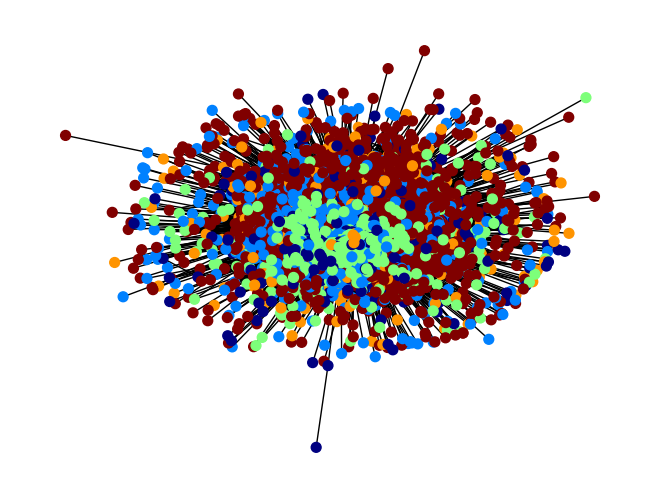

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a layout for our nodes
layout = nx.spring_layout(B, seed=42)  # Using spring layout

# Drawing the graph specifying colors by community
node_color = [data['community'] for _, data in B.nodes(data=True)]
nx.draw(B, pos=layout, node_color=node_color, node_size=50, with_labels=False, cmap=plt.cm.jet)

# If the graph is too dense, you might want to only label some nodes or adjust the node size
plt.show()


In [24]:
degrees_M = dict(B.degree())
degree_centrality_M = nx.degree_centrality(B)
betweenness_centrality_M = nx.betweenness_centrality(B)
closeness_centrality_M = nx.closeness_centrality(B)
clustering_coefficients_M = nx.clustering(B)
modularity_M = community_louvain.modularity(partition, B)

In [25]:
# Calculate degree of each node and then the average
average_degree = sum(degrees_M.values()) / len(degrees_M)
print("Average Degree:", average_degree)

# Calculate clustering coefficient for each node and then the average
average_clustering_coefficient = sum(clustering_coefficients_M.values()) / len(clustering_coefficients_M)
print("Average Clustering Coefficient:", average_clustering_coefficient)

# Calculate betweenness centrality of each node and then the average
average_betweenness_centrality = sum(betweenness_centrality_M.values()) / len(betweenness_centrality_M)
print("Average Betweenness Centrality:", average_betweenness_centrality)

# Calculate closeness centrality of each node and then the average
average_closeness_centrality = sum(closeness_centrality_M.values()) / len(closeness_centrality_M)
print("Average Closeness Centrality:", average_closeness_centrality)

# Calculate degree centrality of each node and then the average
average_degree_centrality = sum(degree_centrality_M.values()) / len(degree_centrality_M)
print("Average Degree Centrality:", average_degree_centrality)

# Modularity of the community structure
print("Modularity:", modularity_M)


Average Degree: 92.25653297597397
Average Clustering Coefficient: 0.0010462975814667704
Average Betweenness Centrality: 0.00017426144843882683
Average Closeness Centrality: 0.357796120150024
Average Degree Centrality: 0.008831756938155565
Modularity: 0.18674019365249353


The refined analysis of network statistics offers a comprehensive view of the e-commerce platform's customer-product interaction network. With an average degree of approximately 92.26, the network maintains a high level of connectivity, suggesting robust interactions among customers and a wide variety of products. Despite this extensive connectivity, the average clustering coefficient remains very low at approximately 0.0010. This indicates minimal clustering within the network, implying that customers who purchase certain products do not tend to buy other similar items in tightly knit groups.

The average betweenness centrality is also low at about 0.00017, reinforcing the notion that no single customer or product acts as a critical gateway controlling the flow of transactions through the network. This scenario depicts a decentralized pattern of interactions where influence is dispersed across many nodes rather than being concentrated. Moreover, the average closeness centrality at 0.3578 suggests that while nodes are not centrally influential, they are relatively close to each other in terms of network paths, facilitating rapid spread and access across the network.

The average degree centrality, standing at 0.0088, further supports the widespread and relatively uniform connectivity among the nodes, without significant centralization. The modularity, slightly reduced to 0.1867, indicates a moderate level of community structure within the network. This shows that there are discernible groups within the network that interact more frequently amongst themselves than with others, though these groups are not sharply divided.

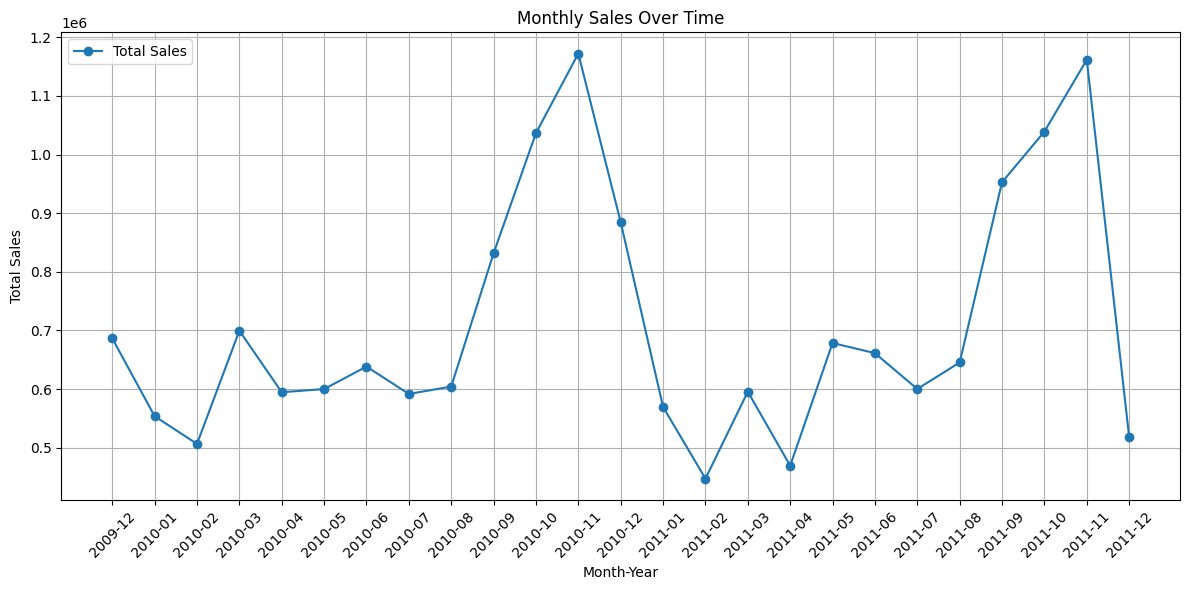

In [20]:
# Aggregate total sales by Year and Month
monthly_sales = df.groupby(['Year', 'Month']).agg(Total_Sales=('TotalPrice', 'sum')).reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Total_Sales'], marker='o', linestyle='-', label='Total Sales')
plt.title('Monthly Sales Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.xticks(ticks=range(len(monthly_sales)), labels=[f"{y}-{m:02d}" for y, m in zip(monthly_sales['Year'], monthly_sales['Month'])], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt

# Load and prepare your DataFrame
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create a dictionary that maps StockCode to Description
product_descriptions = df.drop_duplicates('StockCode').set_index('StockCode')['Description'].to_dict()

# Create a dictionary to hold the monthly networks
monthly_networks = defaultdict(nx.Graph)

# Segment data by month and build network graphs with edge weights
for name, group in df.groupby([df['InvoiceDate'].dt.year, df['InvoiceDate'].dt.month]):
    G = nx.Graph()
    for _, row in group.iterrows():
        edge = (row['Customer ID'], row['StockCode'])
        weight = row['TotalPrice']
        if G.has_edge(*edge):
            G.edges[edge]['weight'] += weight
        else:
            G.add_edge(*edge, weight=weight)
    monthly_networks[name] = G

In [22]:
# Calculate centrality measures and store the top nodes
all_influential_nodes = {}
Centrality_data_Monthwise = {}

for month, G in monthly_networks.items():
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    closeness_centrality = nx.closeness_centrality(G, distance='weight')

    top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

    all_influential_nodes[month] = {
        'degree': top_degree,
        'betweenness': top_betweenness,
        'closeness': top_closeness
    }

    # Store complete centrality data
    Centrality_data_Monthwise[month] = {
        'degree': degree_centrality,
        'betweenness': betweenness_centrality,
        'closeness': closeness_centrality
    }


In [23]:
import pickle

# Optionally, serialize the data for later use
with open('centrality_data_monthwise.pkl', 'wb') as f:
    pickle.dump(Centrality_data_Monthwise, f)

with open('top_influential_nodes_monthwise.pkl', 'wb') as f:
    pickle.dump(all_influential_nodes, f)


In [24]:
# Ensure all StockCodes have descriptions, handle missing cases
product_descriptions = df.drop_duplicates('StockCode').set_index('StockCode')['Description'].to_dict()

# Check for any StockCode without a description
missing_descriptions = {code: 'No Description Available' for code in df['StockCode'].unique() if code not in product_descriptions}
product_descriptions.update(missing_descriptions)

# Now, product_descriptions should have entries for all StockCodes

for month, metrics in all_influential_nodes.items():
    print(f"Month-Year: {month}")
    for measure, nodes in metrics.items():
        print(f"Top 5 nodes by {measure} centrality:")
        for node in nodes:
            node_label = product_descriptions.get(node[0], f"No Description (Customer ID: {node[0]})")
            print(f"  Node: {node_label}, Centrality: {node[1]:.4f}")
    print("\n")  # Newline for better separation


Month-Year: (2009, 12)
Top 5 nodes by degree centrality:
  Node: No Description (Customer ID: 17841), Centrality: 0.0844
  Node: WHITE HANGING HEART T-LIGHT HOLDER, Centrality: 0.0599
  Node: No Description (Customer ID: 15311), Centrality: 0.0561
  Node: No Description (Customer ID: 14606), Centrality: 0.0553
  Node: No Description (Customer ID: 14156), Centrality: 0.0539
Top 5 nodes by betweenness centrality:
  Node: No Description (Customer ID: 15581), Centrality: 0.1349
  Node: REX CASH+CARRY JUMBO SHOPPER, Centrality: 0.1076
  Node: No Description (Customer ID: 15917), Centrality: 0.1049
  Node: No Description (Customer ID: 14606), Centrality: 0.0903
  Node: SET 12 RETRO WHITE CHALK STICKS, Centrality: 0.0752
Top 5 nodes by closeness centrality:
  Node: No Description (Customer ID: 15581), Centrality: 0.0694
  Node: PACK OF 60 DINOSAUR CAKE CASES, Centrality: 0.0693
  Node: No Description (Customer ID: 17865), Centrality: 0.0693
  Node: No Description (Customer ID: 14087), Central

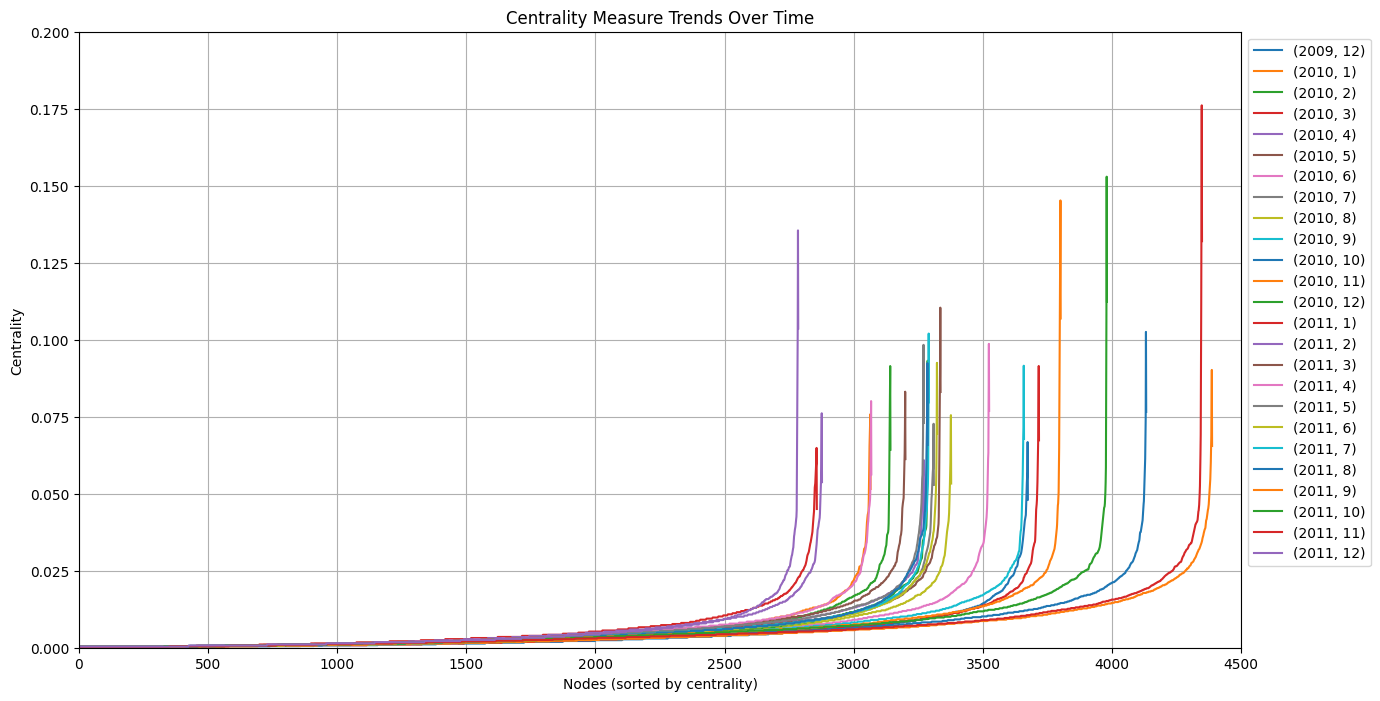

In [25]:
import numpy as np

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_centrality_trends(centrality_data):
    plt.figure(figsize=(15, 8))  # Bigger figure to better differentiate the lines
    for month, centrality_dict in centrality_data.items():
        sorted_centrality = sorted(list(centrality_dict.values()))
        # Apply smoothing here if the graph is too noisy
        smoothed_centrality = smooth(sorted_centrality, 3)  # Adjust this for more or less smoothing
        plt.plot(smoothed_centrality, label=str(month))
    plt.title('Centrality Measure Trends Over Time')
    plt.xlabel('Nodes (sorted by centrality)')
    plt.ylabel('Centrality')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.grid(True)  # Adding grid for better readability
    plt.xlim(0, 4500)  # Adjust as necessary to focus on important part of the data
    plt.ylim(0, 0.2)  # Adjust as necessary to focus on important part of the data
    #plt.savefig('centrality_trends_over_time.png', bbox_inches='tight')  # Save the figure


plot_centrality_trends({month: nx.degree_centrality(G) for month, G in monthly_networks.items()})


In [26]:
import networkx as nx

# Assume 'B' is your bipartite graph created in earlier tasks
pagerank_scores = nx.pagerank(B, alpha=0.85)  # alpha is the damping parameter typically set between 0.8 and 0.9

# Convert PageRank scores to a sorted list for recommendations
sorted_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)


In [27]:
top_recommendations = [node for node, score in sorted_pagerank if node in product_nodes][:10]  # Top 10 products

# Fetch product descriptions if available
product_descriptions = {product: df[df['StockCode'] == product]['Description'].iloc[0] for product in top_recommendations}

print("Top 10 Recommended Products:")
for product, description in product_descriptions.items():
    print(f"Product Code: {product}, Description: {description}")


Top 10 Recommended Products:
Product Code: 85123A, Description: WHITE HANGING HEART T-LIGHT HOLDER
Product Code: 22423, Description: REGENCY CAKESTAND 3 TIER
Product Code: 22138, Description: BAKING SET 9 PIECE RETROSPOT 
Product Code: 21212, Description: PACK OF 72 RETRO SPOT CAKE CASES
Product Code: 85099B, Description: JUMBO BAG RED WHITE SPOTTY 
Product Code: 84879, Description: ASSORTED COLOUR BIRD ORNAMENT
Product Code: 47566, Description: PARTY BUNTING
Product Code: 22139, Description: RETRO SPOT TEA SET CERAMIC 11 PC 
Product Code: 22086, Description: PAPER CHAIN KIT 50'S CHRISTMAS 
Product Code: 22469, Description: HEART OF WICKER SMALL


In [28]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Create a pivot table where rows are customers, columns are products, and values are the quantity of products purchased
user_item_matrix = df.pivot_table(index='Customer ID', columns='StockCode', values='Quantity', aggfunc='sum', fill_value=0)

# Display the first few rows of the matrix to check it
user_item_matrix.head()


StockCode,10002,10080,10109,10120,10123C,10123G,10124A,10124G,10125,10133,...,90214Z,BANK CHARGES,C2,D,DOT,M,PADS,POST,SP1002,TEST002
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,10,0,0
12349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,0
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(user_item_matrix)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

# Display the similarity matrix
similarity_df.head()

Customer ID,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,...,18278,18279,18280,18281,18282,18283,18284,18285,18286,18287
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,1.000000,0.000000,0.000000,0.000003,0.000000,0.000000,2.554411e-07,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,8.762817e-07,0.000000
12347,0.000000,1.000000,0.146919,0.011852,0.018624,0.039675,2.385166e-02,0.026772,0.024015,0.378701,...,0.014905,0.0,0.020046,0.033486,0.011122,0.096335,0.026943,0.0,3.307103e-02,0.065679
12348,0.000000,0.146919,1.000000,0.000220,0.000309,0.000000,1.043401e-03,0.000000,0.011747,0.208666,...,0.000000,0.0,0.000000,0.000000,0.000000,0.170006,0.000000,0.0,0.000000e+00,0.062229
12349,0.000003,0.011852,0.000220,1.000000,0.026632,0.011050,1.474903e-01,0.230884,0.004490,0.020046,...,0.017185,0.0,0.001206,0.004294,0.005903,0.097418,0.096031,0.0,4.629901e-02,0.044708
12350,0.000000,0.018624,0.000309,0.026632,1.000000,0.000000,1.305029e-03,0.060057,0.000000,0.000000,...,0.000000,0.0,0.000000,0.072598,0.000000,0.022439,0.000000,0.0,3.069845e-02,0.000000


In [30]:
def recommend_products(user_id, user_item_matrix, similarity_df, top_n=10):
    # Get the most similar users to the given user
    similar_users = similarity_df[user_id].sort_values(ascending=False).index[1:]  # Ignore self-comparison by starting from index 1
    recommended_products = set()
    
    for similar_user in similar_users:
        # Get products bought by similar users
        products_bought_by_similar = user_item_matrix.loc[similar_user]
        products_bought_by_similar = products_bought_by_similar[products_bought_by_similar > 0].index.values
        
        # Filter out products the user has already bought
        products_already_bought = user_item_matrix.loc[user_id]
        products_already_bought = products_already_bought[products_already_bought > 0].index.values
        
        # Add new products to the recommendation list
        new_recommendations = set(products_bought_by_similar) - set(products_already_bought)
        recommended_products.update(new_recommendations)
        
        if len(recommended_products) >= top_n:
            break
    
    return list(recommended_products)[:top_n]

# Example: Recommend products for a specific user
user_id = '12350'  # Change to a valid Customer ID from the dataset
recommendations = recommend_products(user_id, user_item_matrix, similarity_df)
print(f"Recommended products for user {user_id}: {recommendations}")


Recommended products for user 12350: ['22362', '21892', '20713', '22087', '22364', '22415', '20898', '21208', '82581', '21195']


In [31]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

# Define the scale of your ratings
min_rating = df['TotalPrice'].min()
max_rating = df['TotalPrice'].max()

# Load the data into a format that Surprise can use
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(df[['Customer ID', 'StockCode', 'TotalPrice']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.25)


#### Train Collaborative Filtering Model

In [32]:
# Use matrix factorization (SVD)
algo = SVD()
algo.fit(trainset)

# Test the algorithm on the test set
predictions = algo.test(testset)


#### Evaluate the Model

In [33]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

df['NormalizedPrice'] = np.log1p(df['TotalPrice'])  # Log transformation

# Update the dataset for Surprise
reader = Reader(rating_scale=(df['NormalizedPrice'].min(), df['NormalizedPrice'].max()))
data = Dataset.load_from_df(df[['Customer ID', 'StockCode', 'NormalizedPrice']], reader)

# Use SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and then print results
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Output average RMSE and MAE across folds
print(f"Average RMSE: {results['test_rmse'].mean()}")
print(f"Average MAE: {results['test_mae'].mean()}")


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.5262  0.5223  0.5276  0.5287  0.5265  0.5263  0.0022  
MAE (testset)     0.3772  0.3762  0.3791  0.3792  0.3780  0.3779  0.0011  
Fit time          7.28    7.52    7.55    7.54    7.50    7.48    0.10    
Test time         1.13    1.56    1.19    0.69    1.16    1.15    0.28    
Average RMSE: 0.5262505072709069
Average MAE: 0.37794271438239446


In [34]:
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split

# Normalize TotalPrice
df['NormalizedPrice'] = np.log1p(df['TotalPrice'])  # Log transformation

# Update the dataset for Surprise
reader = Reader(rating_scale=(df['NormalizedPrice'].min(), df['NormalizedPrice'].max()))
data = Dataset.load_from_df(df[['Customer ID', 'StockCode', 'NormalizedPrice']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Item-based Collaborative Filtering
item_based_algo = KNNBasic(sim_options={'user_based': False})
item_based_algo.fit(trainset)
item_predictions = item_based_algo.test(testset)
item_rmse = accuracy.rmse(item_predictions)
item_mae = accuracy.mae(item_predictions)

# User-based Collaborative Filtering
user_based_algo = KNNBasic(sim_options={'user_based': True})
user_based_algo.fit(trainset)
user_predictions = user_based_algo.test(testset)
user_rmse = accuracy.rmse(user_predictions)
user_mae = accuracy.mae(user_predictions)

# Print the evaluation results
print("Item-based CF RMSE:", item_rmse)
print("Item-based CF MAE:", item_mae)
print("User-based CF RMSE:", user_rmse)
print("User-based CF MAE:", user_mae)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5732
MAE:  0.4111
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.5723
MAE:  0.3859
Item-based CF RMSE: 0.5731513273611589
Item-based CF MAE: 0.41106050472257627
User-based CF RMSE: 0.5723410514710571
User-based CF MAE: 0.3859149279299502
